In [7]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt
from matplotlib import pyplot
import numpy

# Utils section

In [11]:

# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = tf.keras.Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [12]:
# load dataset
series = read_csv('shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
series

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
1901-06-01    168.5
1901-07-01    231.8
1901-08-01    224.5
1901-09-01    192.8
1901-10-01    122.9
1901-11-01    336.5
1901-12-01    185.9
1902-01-01    194.3
1902-02-01    149.5
1902-03-01    210.1
1902-04-01    273.3
1902-05-01    191.4
1902-06-01    287.0
1902-07-01    226.0
1902-08-01    303.6
1902-09-01    289.9
1902-10-01    421.6
1902-11-01    264.5
1902-12-01    342.3
1903-01-01    339.7
1903-02-01    440.4
1903-03-01    315.9
1903-04-01    439.3
1903-05-01    401.3
1903-06-01    437.4
1903-07-01    575.5
1903-08-01    407.6
1903-09-01    682.0
1903-10-01    475.3
1903-11-01    581.3
1903-12-01    646.9
Name: Sales, dtype: float64

In [15]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)


# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
print('Diff value:', diff_values)
print('Supervised:', supervised_values)


Diff value: 0    -120.1
1      37.2
2     -63.8
3      61.0
4     -11.8
5      63.3
6      -7.3
7     -31.7
8     -69.9
9     213.6
10   -150.6
11      8.4
12    -44.8
13     60.6
14     63.2
15    -81.9
16     95.6
17    -61.0
18     77.6
19    -13.7
20    131.7
21   -157.1
22     77.8
23     -2.6
24    100.7
25   -124.5
26    123.4
27    -38.0
28     36.1
29    138.1
30   -167.9
31    274.4
32   -206.7
33    106.0
34     65.6
dtype: float64
Supervised: [[   0.  -120.1]
 [-120.1   37.2]
 [  37.2  -63.8]
 [ -63.8   61. ]
 [  61.   -11.8]
 [ -11.8   63.3]
 [  63.3   -7.3]
 [  -7.3  -31.7]
 [ -31.7  -69.9]
 [ -69.9  213.6]
 [ 213.6 -150.6]
 [-150.6    8.4]
 [   8.4  -44.8]
 [ -44.8   60.6]
 [  60.6   63.2]
 [  63.2  -81.9]
 [ -81.9   95.6]
 [  95.6  -61. ]
 [ -61.    77.6]
 [  77.6  -13.7]
 [ -13.7  131.7]
 [ 131.7 -157.1]
 [-157.1   77.8]
 [  77.8   -2.6]
 [  -2.6  100.7]
 [ 100.7 -124.5]
 [-124.5  123.4]
 [ 123.4  -38. ]
 [ -38.    36.1]
 [  36.1  138.1]
 [ 138.1 -167.9]
 [-167.9  274.

In [17]:
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# Training section

In [19]:
# repeat experiment
repeats = 3
error_scores = list()
for r in range(repeats):
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 3, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)


1) Test RMSE: 123.673
2) Test RMSE: 144.725
3) Test RMSE: 127.186


             rmse
count    3.000000
mean   131.861566
std     11.278022
min    123.673477
25%    125.429622
50%    127.185767
75%    135.955611
max    144.725456


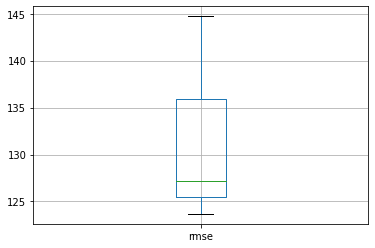

In [20]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()